# 序列模型

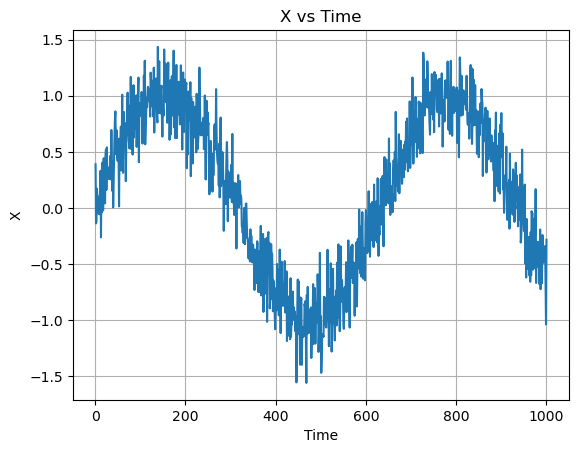

In [2]:
"""构造一个时间序列"""
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt
T = 1000
time = torch.arange(1, T+1, dtype = torch.float32)
x = torch.sin(time * 0.01) + torch.randn((T)) * 0.2
plt.plot(time, x)  # 绘制折线图
plt.xlabel('Time')  # 添加x轴标签
plt.ylabel('X')  # 添加y轴标签
plt.title('X vs Time')  # 添加标题
plt.grid()  # 显示网格
plt.show()  # 显示图形

In [3]:
"""马尔可夫假设，看t-1到t-4个的x值"""
import self_d2l
tau = 4
features = torch.zeros(T - tau, tau)
for i in range(tau):
    features[:, i] = x[i: T - tau + i] # 按0，1，2，3开头，取四个tau长度的数组，预测后面的数
labels = x[tau:].reshape(-1,1) # tau到最后是正确结果
batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = self_d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [5]:
def get_net():
    net = nn.Sequential(
        nn.Linear(4,10),
        nn.ReLU(),
        nn.Linear(10,1)
    )
    return net


In [6]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for i in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f"epoch,{i+1} loss: {d2l.evaluate_loss(net, train_iter, loss):.6f}")
# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')
net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch,1 loss: 0.067769
epoch,2 loss: 0.060336
epoch,3 loss: 0.056680
epoch,4 loss: 0.056322
epoch,5 loss: 0.058728


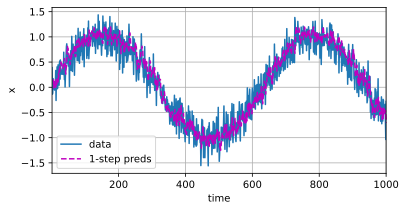

In [7]:
"""预测"""
onestep_preds = net(features)
d2l.plot([time, time[tau:]],[x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

没有预测噪音，结果有受噪声影响

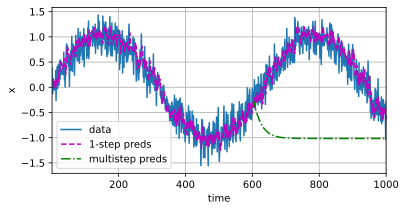

In [8]:
"""多步预测"""
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

用预测的数据来预测下一个数据，误差累积。